# Comment classification using machine learning and deep learning 

Libraries needed

In [4]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

Creating a new dataset with the clean comments

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.lower()   #Convert to lowercase
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)  #Remove special characters
    text = re.sub(r'\d+', '', text)   #Remove numbers
    text = text.translate(str.maketrans('','',string.punctuation))    #Remove punctuation
    text = text.strip()   #Remove whitespaces
    word_tokens = word_tokenize(text)    #Tokenize the sentence
    text = [w for w in word_tokens if not w in stop_words]   #Remove stopwords
    text = [stemmer.stem(w) for w in text ]   #Stemming
    text = [lemmatizer.lemmatize(w) for w in text]   
    clean_text = ''
    for word in text:
        clean_text = clean_text + word + ' '
    return clean_text.strip()

Location = r'/home/orestis/Desktop/data/train.csv'
df = pd.read_csv(Location)

del df['Date']


comments = df['Comment']
categories = df['Insult']

clean_comments = list()

for comment in comments:
    clean_comments.append(preprocess(comment))

    
#Create a new dataframe with the clean comments
DataSet = list(zip(clean_comments,categories))

df = pd.DataFrame(data=DataSet,columns=['Comments','Categories'])
df.to_csv('comments.csv',index=False,header=False)

Split the dataset to train and test comments

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df['Comments'],df['Categories'],random_state=0)

Testing the naive bayes classifier using MultinomialNB

In [7]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

prediction = clf.predict(count_vect.transform([preprocess("You are fucking stupid")]))

if prediction == 1:
    print("Comment is offensive")
else:
    print("Comment is not offensive")

Comment is offensive


Compare the scores of different models

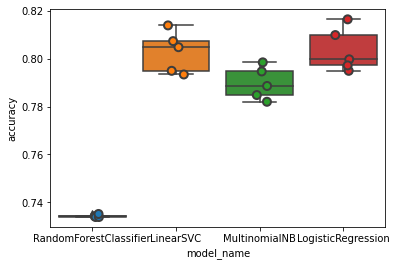

model_name
LinearSVC                 0.802887
LogisticRegression        0.803647
MultinomialNB             0.789715
RandomForestClassifier    0.734229
Name: accuracy, dtype: float64

In [8]:

models = [RandomForestClassifier(n_estimators=200,max_depth=3,random_state=0),
            LinearSVC(),
            MultinomialNB(),
            LogisticRegression(random_state=0)]

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Comments).toarray()
labels = df.Categories


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
    for fold_idx,accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))

cv_df = pd.DataFrame(entries,columns=['model_name','fold_idx','accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').accuracy.mean()

## Try deep learning to achieve a higher score

Load the clean dataset

In [9]:

filepath = r'/home/orestis/Desktop/comments.csv'
df = pd.read_csv(filepath, names=['comment', 'label'],header=None)
print(df.iloc[0])

comment    fuck dad
label             1
Name: 0, dtype: object


Fill nan comments with empty text and split the dataset to train and test comments

In [10]:

df.fillna('')

comments = df['comment'].values.astype('U')
y = df['label'].values

comments_train, comments_test, y_train, y_test = train_test_split(
   comments, y, test_size=0.25, random_state=1000)

Using bag of words model to vectorize the comments

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(comments_train)

X_train = vectorizer.transform(comments_train)
X_test  = vectorizer.transform(comments_test)
X_train

<2960x12316 sparse matrix of type '<class 'numpy.int64'>'
	with 46337 stored elements in Compressed Sparse Row format>

Trying logistic regression model

In [12]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8206686930091185


Using Keras Sequential model

In [13]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Configure learning process.We use binary crossentropy for loss function and the Adam optimizer

In [14]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                123170    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 123,181
Trainable params: 123,181
Non-trainable params: 0
_________________________________________________________________


Start training

In [15]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Measure the accuracy of the model

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Training Accuracy: 0.9983
Testing Accuracy:  0.7335


Visualize the loss and accuracy for the training and testing data based on History callback

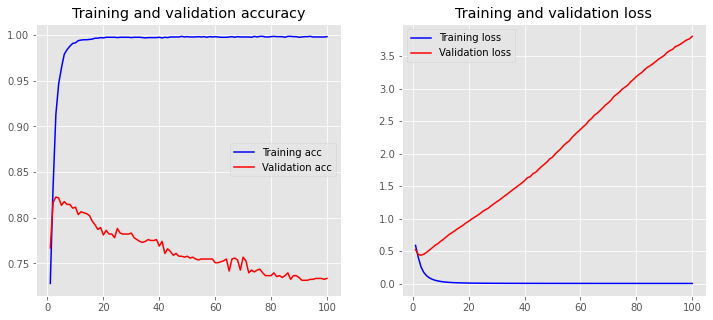

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

## Word Embeddings

Using the Tokenizer utility class to vectorize a text corpus into a list of integers

In [18]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(comments_train)

X_train = tokenizer.texts_to_sequences(comments_train)
X_test = tokenizer.texts_to_sequences(comments_test)

vocab_size = len(tokenizer.word_index) + 1

print(comments_train[2])
print(X_train[2])

fuck behav prick
[4, 3024, 1884]


Pad the sequence of words with zeros so the text sequences have the same length of words

In [19]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

print(X_train[10,:])

[  51 4524  232    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Keras Embedding Layer

In [21]:

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           617000    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 667,021
Trainable params: 667,021
Non-trainable params: 0
_________________________________________________________________


Train the model

Training Accuracy: 0.9966
Testing Accuracy:  0.7771


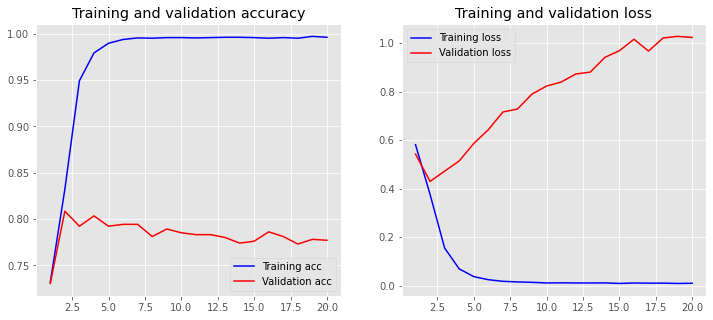

In [22]:
history = model.fit(X_train, y_train,epochs=20,verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


Using GlobalMaxPooling1D layer after the embedding to take the maximum value of all feautures in the pool for each feature dimension

In [23]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))


model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           617000    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 617,521
Trainable params: 617,521
Non-trainable params: 0
_________________________________________________________________


Same procedure for training

Training Accuracy: 0.9966
Testing Accuracy:  0.7730


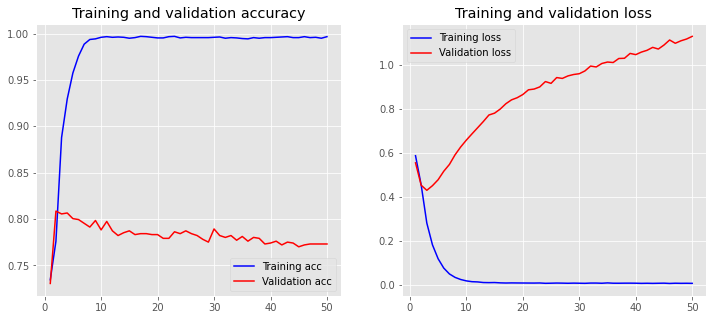

In [24]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


## Using Pretrained Word Embeddings

Using the GloVe word embeddings from the Stanford NLP Group

Since we don't need all words,we can focus on only the words we have in our vocabulary.We only have a limited number of words in our vocabulary so we can skip most of the words in the pretrained word embeddings

In [26]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

filepath = '/home/orestis/Desktop/glove.6B/glove.6B.50d.txt'
embedding_matrix = create_embedding_matrix(filepath,tokenizer.word_index,embedding_dim)

Use the embedding matrix in training.First check how many of the embedding vectors are nonzero

In [27]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size


0.47893030794165314

Performance when using the GlobalMaxPool1D layer

In [28]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           617000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 617,521
Trainable params: 521
Non-trainable params: 617,000
_________________________________________________________________


Training Accuracy: 0.7936
Testing Accuracy:  0.7568


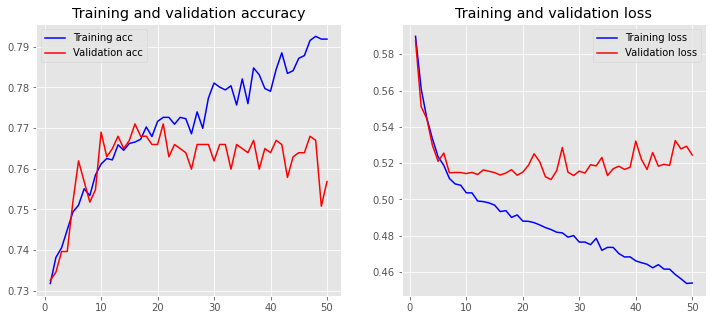

In [29]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


Allow the embedding to be trained by using trainable=True

In [30]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           617000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 617,521
Trainable params: 617,521
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9966
Testing Accuracy:  0.7933


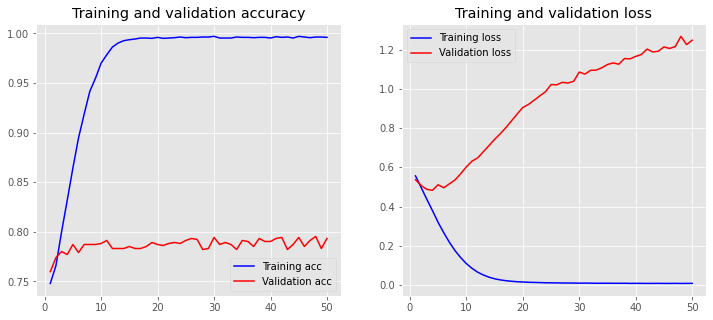

In [31]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


## Convolutional Neural Networks

In [32]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1234000   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 1,299,429
Trainable params: 1,299,429
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9963
Testing Accuracy:  0.7913


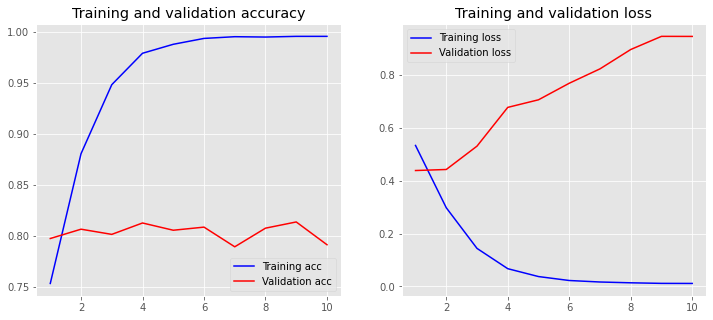

In [33]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
